<a href="https://colab.research.google.com/github/namanmeena/covid19-classification-using-xray/blob/master/Covid19_Classification_Using_XRay.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# FastAI - COVID19 Classification using Chest XRay

Inspired by [Adrian Rosebrock's blog - 'Detecting COVID-19 in X-ray images with Keras, TensorFlow, and Deep Learning
'](https://www.pyimagesearch.com/2020/03/16/detecting-covid-19-in-x-ray-images-with-keras-tensorflow-and-deep-learning/)

## Disclaimer:
**The methods and techniques used in this post are meant for educational purposes only. This is not a scientifically rigorous study, nor will it be published in a journal. This article is for people who are interested in (1) Computer Vision/Deep Learning and want to learn via practical, hands-on methods and (2) are inspired by current events. I kindly ask that you treat it as such.**

## About FastAI
Fast.ai is a brainchild of Rachel Thomas and Jeremy Howard. The idea behind FastAI is to democratize AI to reach people from all domains.

Keras is another library, built on top of TensorFlow and therefore provides abstraction over Google's TensorFlow. Although, being very powerful, it still requires you to write a lot of lines of code to get things done. Therefore, to quickly get started with experimentation, FastAI is good and my personal preference.

## About Dataset

The dataset used in this use-case is from [Kaggle - 'COVID-19 RADIOGRAPHY DATABASE (Winner of the COVID-19 Dataset Award)
'](https://www.kaggle.com/tawsifurrahman/covid19-radiography-database)


### We are going to use kaggle api to download the dataset

In [1]:
# Installing Kaggle api
!pip install kaggle

## Script to download and extract dataset

In [5]:
%%bash

token='' # Put your token
token_dir="/root/.kaggle"
competition="covid19-xray"
dataset_path="kaggle_datasets"
competition_dataset_path="$dataset_path/$competition"

# Removing existing dir
rm -rf $token_dir
rm -rf $competition_dataset_path

# Creating directories
mkdir -p $token_dir
mkdir -p $competition_dataset_path

# Placing kaggle token
echo $token > $token_dir/kaggle.json

# Giving permission to token
chmod 600 $token_dir/kaggle.json

# Downloading dataset using kaggle
kaggle datasets download -d tawsifurrahman/covid19-radiography-database -p $competition_dataset_path

# Extracting dataset
unzip -qq kaggle_datasets/covid19-xray/covid19-radiography-database.zip -d $competition_dataset_path

# Cleanup some files as they may interfere with reading fastai
rm kaggle_datasets/covid19-xray/'COVID-19_Radiography_Dataset'/*.xlsx
rm kaggle_datasets/covid19-xray/'COVID-19_Radiography_Dataset'/*.txt

100%|##########| 745M/745M [00:04<00:00, 162MB/s]


In [7]:
dataset_name = "COVID-19_Radiography_Dataset"

In [8]:
!ls -l 'kaggle_datasets/covid19-xray/{dataset_name}'

total 820
drwxr-xr-x 2 root root 135168 May 14 07:31  COVID
drwxr-xr-x 2 root root 266240 May 14 07:31  Lung_Opacity
drwxr-xr-x 2 root root 368640 May 14 07:32  Normal
drwxr-xr-x 2 root root  69632 May 14 07:32 'Viral Pneumonia'


Let's see how many files are present in each directory. The number is 1 less than actual number of files.


In [10]:
!echo "Covid19 files: " `ls -l kaggle_datasets/covid19-xray/'{dataset_name}'/COVID | wc -l`
!echo "Normal files: " `ls -l kaggle_datasets/covid19-xray/'{dataset_name}'/Normal | wc -l`
!echo "Viral Pneumonia files: " `ls -l kaggle_datasets/covid19-xray/'{dataset_name}/Viral Pneumonia' | wc -l`
!echo "Lung_Opacity files: " `ls -l kaggle_datasets/covid19-xray/'{dataset_name}/Lung_Opacity' | wc -l`

Covid19 files:  3617
Normal files:  10193
Viral Pneumonia files:  1346
Lung_Opacity files:  6013


In [11]:
BASE_PATH = "kaggle_datasets/covid19-xray"
PROJECT_PATH = f"{BASE_PATH}/{dataset_name}"

## Let's Start

In [12]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [13]:
from fastai.vision import *
from fastai.metrics import *

In [14]:
## Suppressing warnings from FastAI warnings
warnings.filterwarnings("ignore", category=UserWarning, module="torch.nn.functional")

## Checking GPU assigned
It will help us to find out its memory which will help in deciding the batch size.

In [15]:
!nvidia-smi

Fri May 14 07:33:50 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P8    29W / 149W |      3MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [16]:
bs=64

## Creating Image DataBunch
We are not going to augment the data since it is a chest XRay and augmenting it may lose the actual information that the xray conveys. We can use some augmentation like brightness, zooming and crop but for this use case I'm going to skip that.

If you feel the need to augment, you can do them and refer to the [documentation](https://docs.fast.ai/vision.transform.html#get_transforms)

In [17]:
data = (ImageList.from_folder(PROJECT_PATH) \
    # Splitting dataset with 80% for traininig and 20% for validation 
    .split_by_rand_pct(seed=99, valid_pct=0.2) \
    # Using labels from folders
    .label_from_folder() \
    # Resizing without augmentation
    .transform(size=224) \
    # Creating a DataBunch with the batch size
    .databunch(bs=bs) \
    # Normalizing the colors with ImageNet dataset's avg RGB stats
    .normalize(imagenet_stats))

data.save("covid19_data.pkl")

In [18]:
# Will need if the
# del data
# del learn

In [19]:
# FastAI provides you the flexibility to change the batch size on loading the DataBunch from disk.
bs=64
data = load_data(PROJECT_PATH, "covid19_data.pkl", bs=bs)
data

ImageDataBunch;

Train: LabelList (16932 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
COVID,COVID,COVID,COVID,COVID
Path: kaggle_datasets/covid19-xray/COVID-19_Radiography_Dataset;

Valid: LabelList (4233 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
Normal,Lung_Opacity,Normal,Normal,Viral Pneumonia
Path: kaggle_datasets/covid19-xray/COVID-19_Radiography_Dataset;

Test: None

## Visualizing the DataBunch created

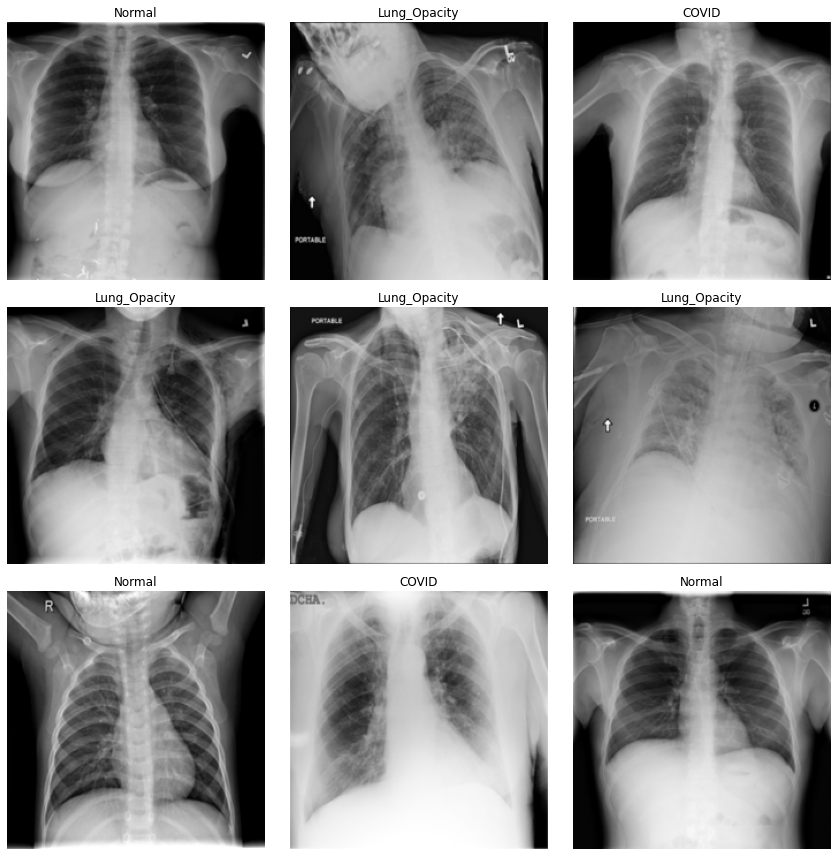

In [20]:
data.show_batch(rows=3, figsize=(12, 12))

## Create Learner with Resnet50

In [21]:
# Metrics to be used during validation
fscore = FBeta(average='macro', beta=1)
precision = Precision(average='macro')
recall = Recall(average="macro")

# Creating Learner
learn = cnn_learner(data, models.resnet50, metrics=[accuracy, fscore, precision, recall])

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


In [22]:
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv2d(64, 256

### Warming up 
We will warm up and train for 1 epoch so the newly added layers after resnet50 are not randomly initialized when we train by unfreezing the resent50 model.

In [23]:
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,accuracy,f_beta,precision,recall,time
0,0.395989,0.285724,0.902197,0.907370,0.913605,0.901726,04:28


### Saving Stage - 1 (WarmUp)

In [24]:
learn.save("stage-1")

In [25]:
def plot_cf(learner):
  """
  Plotting the Confusion matrix using `ClassificationInterpretation` from FastAI
  args:
    learner - the learner trained
  """
  interp = ClassificationInterpretation.from_learner(learner)

  losses,idxs = interp.top_losses()

  len(data.valid_ds)==len(losses)==len(idxs)
  interp.plot_confusion_matrix(figsize=(6,6))

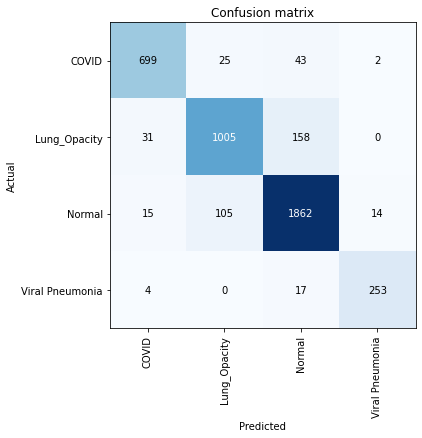

In [26]:
plot_cf(learn)

## Stage - 2
Loading Stage - 1 and Unfreeze the resnet50 model.
We will now train the whole model, but before that we will use `lr_find` method on learner to use an optimal learning rate.

In [27]:
learn.load("stage-1")
learn.unfreeze()

epoch,train_loss,valid_loss,accuracy,f_beta,precision,recall,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


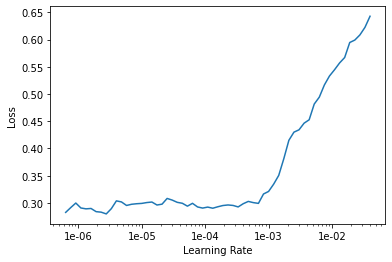

In [28]:
learn.lr_find()
learn.recorder.plot()

## Checkpoint Callback

We are going to use a callback to save our model after each epoch. It will help us restore the model to a previous state if it starts to overfit.

In [29]:
learner_callbacks = [callbacks.SaveModelCallback(learn, every='epoch', monitor='accuracy', name='stage-2')]
lr = slice(2e-6,1e-2/(4.3**2))
lr

slice(2e-06, 0.0005408328826392645, None)

In [30]:
learn.fit_one_cycle(5, max_lr=lr, wd=1e-1, callbacks=learner_callbacks)

epoch,train_loss,valid_loss,accuracy,f_beta,precision,recall,time
0,0.244188,0.229089,0.920624,0.924605,0.932314,0.917455,05:51
1,0.175575,0.190925,0.931254,0.937594,0.944453,0.931085,05:52
2,0.065738,0.225290,0.935743,0.943199,0.943665,0.942751,05:53
3,0.015012,0.233947,0.940468,0.945804,0.949806,0.942187,05:56
4,0.008260,0.242991,0.942121,0.947825,0.953298,0.943137,05:57


In [31]:
learn.save("stage-2")

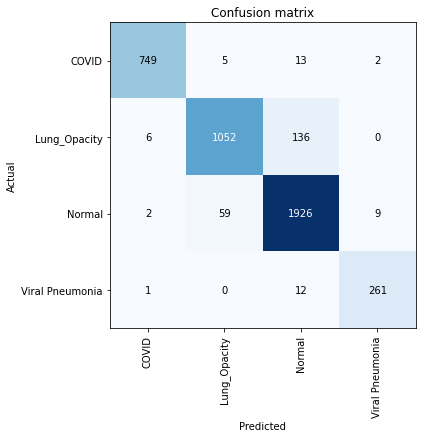

In [32]:
plot_cf(learn)

## Conclusion

Since Stage - 2 had some overfitting issues, we are going to use the checkpointed model `version 1` for prediction now. 

### Note
**This can further be improved by trying out other CNN architectures and by tweaking model parameters such as learning rate and weight decay and may more.**

**We can also use additional information, if we have, as data points and create a [wide and deep model, another really promising approach](https://ai.googleblog.com/2016/06/wide-deep-learning-better-together-with.html).**

## Take-aways
The metrics observed in just 5 epochs after warm-up gives great result even with not so complex architecture of resnet50. 

## Prediction

In [37]:
!ls -lh "{PROJECT_PATH}"/models

total 2.3G
-rw-r--r-- 1 root root 115M May 14 07:39 stage-1.pth
-rw-r--r-- 1 root root 294M May 14 07:47 stage-2_0.pth
-rw-r--r-- 1 root root 294M May 14 07:52 stage-2_1.pth
-rw-r--r-- 1 root root 294M May 14 07:58 stage-2_2.pth
-rw-r--r-- 1 root root 294M May 14 08:04 stage-2_3.pth
-rw-r--r-- 1 root root 294M May 14 08:10 stage-2_4.pth
-rw-r--r-- 1 root root 294M May 14 08:10 stage-2.pth
-rw-r--r-- 1 root root 294M May 14 08:18 stage-3_0.pth
-rw-r--r-- 1 root root  99M May 14 08:11 tmp.pth


### Loading best model to predict

In [38]:
learn.load("stage-2_1")
print("loaded")

loaded


### Creating Prediction Utils

In [39]:
import cv2

def print_percent(outputs):
  """
  Prints the confidence in the prediction in percentage.
  """
  percent_value = np.around(100 * outputs[outputs.argmax()].numpy(), 4)
  print(f"percent: {percent_value}%")

def predict_from_img(image_path):
  """
  Predicts whether the image is 'NORMAL' or 'COVID-19' or has 'Viral Pneumonia'.
  """
  img = open_image(image_path)
  plt.figure(figsize = (10,10))
  plt.imshow(cv2.imread(image_path))
  pred_class, pred_idx, outputs = learn.predict(img)

  prob_malignant = float(outputs[1])

  print(f"Class: {pred_class}")
  print_percent(outputs)

  learn.predict(img)

### Predicting with NORMAL XRAY Image

In [42]:
!ls -l "{PROJECT_PATH}"/Normal/ | head

total 391956
-rw-r--r-- 1 root root 37520 Mar  6 18:45 Normal-10000.png
-rw-r--r-- 1 root root 41370 Mar  6 18:45 Normal-10001.png
-rw-r--r-- 1 root root 36887 Mar  6 18:45 Normal-10002.png
-rw-r--r-- 1 root root 38342 Mar  6 18:45 Normal-10003.png
-rw-r--r-- 1 root root 37396 Mar  6 18:45 Normal-10004.png
-rw-r--r-- 1 root root 38960 Mar  6 18:45 Normal-10005.png
-rw-r--r-- 1 root root 29295 Mar  6 18:45 Normal-10006.png
-rw-r--r-- 1 root root 36828 Mar  6 18:45 Normal-10007.png
-rw-r--r-- 1 root root 41461 Mar  6 18:45 Normal-10008.png


Class: Normal
percent: 94.2865%


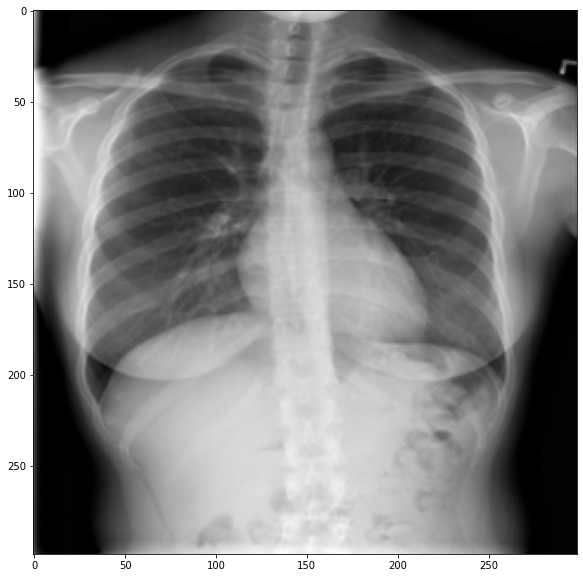

In [43]:
image_path = f"{PROJECT_PATH}/Normal/Normal-10003.png"
predict_from_img(image_path)

### Predicting with COVID-19 XRAY Image

In [44]:
!ls -l "{PROJECT_PATH}"/COVID/ | head

total 133876
-rw-r--r-- 1 root root 33312 Mar  6 18:19 COVID-1000.png
-rw-r--r-- 1 root root 33337 Mar  6 18:19 COVID-1001.png
-rw-r--r-- 1 root root 36320 Mar  6 18:19 COVID-1002.png
-rw-r--r-- 1 root root 37586 Mar  6 18:19 COVID-1003.png
-rw-r--r-- 1 root root 26751 Mar  6 18:19 COVID-1004.png
-rw-r--r-- 1 root root 40117 Mar  6 18:19 COVID-1005.png
-rw-r--r-- 1 root root 38263 Mar  6 18:19 COVID-1006.png
-rw-r--r-- 1 root root 31312 Mar  6 18:19 COVID-1007.png
-rw-r--r-- 1 root root 36355 Mar  6 18:19 COVID-1008.png


Class: COVID
percent: 99.9207%


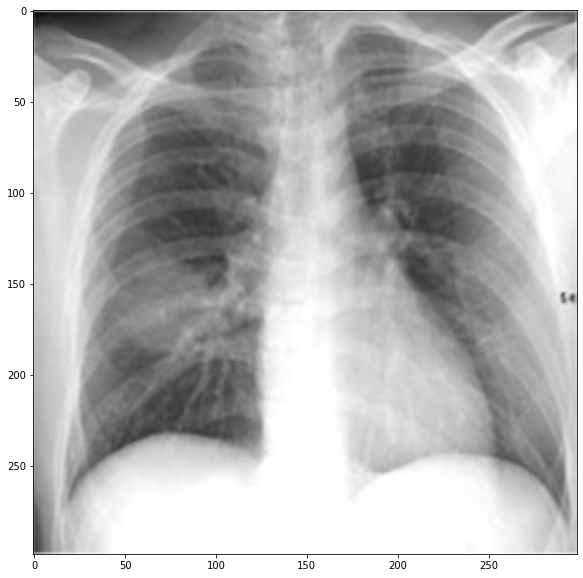

In [45]:
image_path = f"{PROJECT_PATH}/COVID/COVID-1002.png"
predict_from_img(image_path)

### Predicting with Viral Pneumonia XRAY Image

In [46]:
!ls -l "{PROJECT_PATH}/Viral Pneumonia" | head

total 55652
-rw-r--r-- 1 root root 40185 Mar  6 19:01 Viral Pneumonia-1000.png
-rw-r--r-- 1 root root 39189 Mar  6 19:01 Viral Pneumonia-1001.png
-rw-r--r-- 1 root root 43694 Mar  6 19:01 Viral Pneumonia-1002.png
-rw-r--r-- 1 root root 43734 Mar  6 19:01 Viral Pneumonia-1003.png
-rw-r--r-- 1 root root 56961 Mar  6 19:01 Viral Pneumonia-1004.png
-rw-r--r-- 1 root root 56414 Mar  6 19:01 Viral Pneumonia-1005.png
-rw-r--r-- 1 root root 33245 Mar  6 19:01 Viral Pneumonia-1006.png
-rw-r--r-- 1 root root 36252 Mar  6 19:01 Viral Pneumonia-1007.png
-rw-r--r-- 1 root root 38658 Mar  6 19:01 Viral Pneumonia-1008.png


Class: Viral Pneumonia
percent: 99.9985%


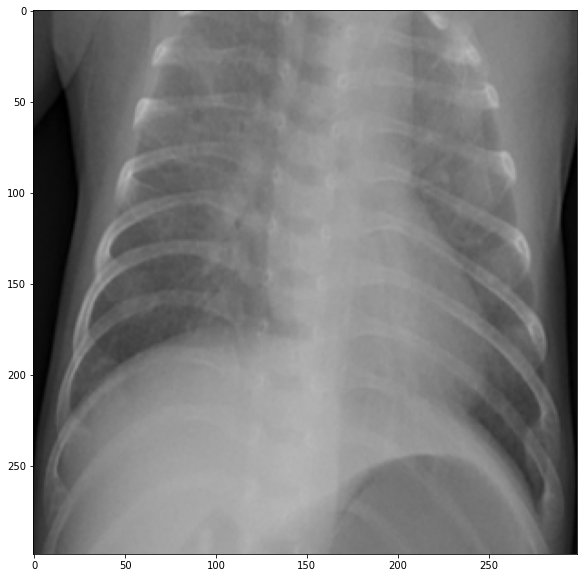

In [47]:
image_path = f"{PROJECT_PATH}/Viral Pneumonia/Viral Pneumonia-1004.png"
predict_from_img(image_path)

### Predicting with Lung Opacity Image

In [48]:
!ls -l "{PROJECT_PATH}/Lung_Opacity" | head

total 218920
-rw-r--r-- 1 root root 29568 Mar  6 18:35 Lung_Opacity-1000.png
-rw-r--r-- 1 root root 32568 Mar  6 18:35 Lung_Opacity-1001.png
-rw-r--r-- 1 root root 37943 Mar  6 18:35 Lung_Opacity-1002.png
-rw-r--r-- 1 root root 32135 Mar  6 18:35 Lung_Opacity-1003.png
-rw-r--r-- 1 root root 39815 Mar  6 18:35 Lung_Opacity-1004.png
-rw-r--r-- 1 root root 33808 Mar  6 18:35 Lung_Opacity-1005.png
-rw-r--r-- 1 root root 37610 Mar  6 18:35 Lung_Opacity-1006.png
-rw-r--r-- 1 root root 35243 Mar  6 18:35 Lung_Opacity-1007.png
-rw-r--r-- 1 root root 37987 Mar  6 18:35 Lung_Opacity-1008.png


Class: Lung_Opacity
percent: 99.7012%


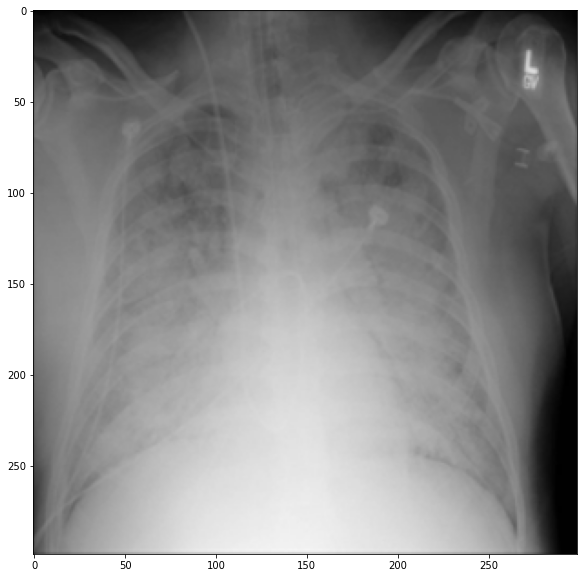

In [50]:
image_path = f"{PROJECT_PATH}/Lung_Opacity/Lung_Opacity-1003.png"
predict_from_img(image_path)

## Final Takeaways

In the end, this was a pretty useful and educational exercise. It show cases the power of Computer Vision and Deep Learning. With ~20,000 images, we were able to determine whether a patient is COVID Positive or has Viral Pneumonia, Lung Opacity or is Normal, which is not easily distinguishable by human eyes.

**Note: Again, this is not a scientifically rigorous study, nor will it be published in a journal and should only be referred to for educational purposes.**

## Thank You